In [1]:
## importing libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.model_selection import train_test_split

## Know your data

In [2]:
## dataset overview
df = pd.read_csv('data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# checking the size of data
df.shape

(6362620, 11)

In [4]:
# checking mathematical statistics
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
## checking nulls in data 

df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
#3 checking duplicates in data
df.duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
6362615    False
6362616    False
6362617    False
6362618    False
6362619    False
Length: 6362620, dtype: bool

### Choosing target variable
the columns isFraud and isFlaggedFraud are the likely candidates for the target variable. Both of these columns represent binary classification labels that could potentially serve as the target variable in a classification analysis.

In summary, the main focus is on identifying potentially fraudulent instances that are flagged, you might prefer the isFlaggedFraud column as your target variable. 
but 
Given that  goal is to identify online payment fraud so then isFraud column seems to be a more appropriate choice for the target variable. 




## EDA

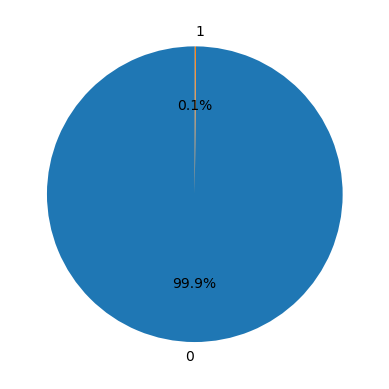

In [8]:
fraud = df['isFraud'].value_counts()
fraud_idx = fraud.index
fraud_val = fraud.values

plt.pie(fraud_val,
        labels=fraud_idx,
        autopct='%1.1f%%',
        startangle=90)
plt.show()

note : from above statistics we can see that data is imbalanced it is important to balance our data 

In [9]:
df[df.isFraud == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


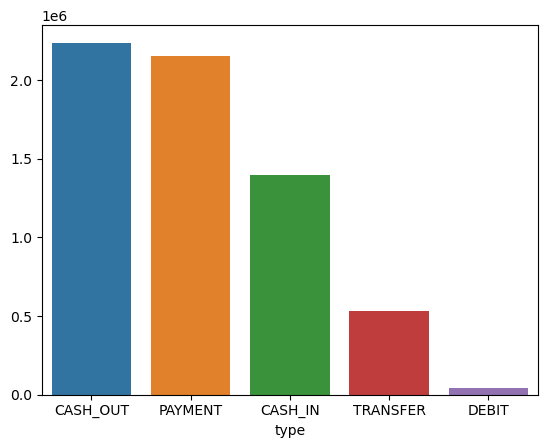

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x = df.type.value_counts().index, y = df.type.value_counts().values)
plt.show()

it looks like that cash out takes the most of the data and then payment so we can conclude that the most of fraud will b e in this two types

In [11]:
## 10 most largest amount of money
df.nlargest(10, 'amount')


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3686583,276,TRANSFER,92445516.64,C1715283297,0.0,0.0,C439737079,9.595980e+03,9.245511e+07,0,0
4060598,300,TRANSFER,73823490.36,C2127282686,0.0,0.0,C753026640,9.362401e+07,1.674475e+08,0,0
4146397,303,TRANSFER,71172480.42,C2044643633,0.0,0.0,C84111522,1.134615e+08,1.846340e+08,0,0
3946920,286,TRANSFER,69886731.30,C1425667947,0.0,0.0,C167875008,1.515387e+08,2.214254e+08,0,0
3911956,284,TRANSFER,69337316.27,C1584456031,0.0,0.0,C1472140329,1.130072e+08,1.823446e+08,0,0
3937152,286,TRANSFER,67500761.29,C811810230,0.0,0.0,C1757599079,8.635615e+07,1.538569e+08,0,0
4105338,302,TRANSFER,66761272.21,C420748282,0.0,0.0,C1073241084,6.874206e+07,1.355033e+08,0,0
3892529,284,TRANSFER,64234448.19,C1139847449,0.0,0.0,C65111466,6.597691e+07,1.663021e+08,0,0
3991638,298,TRANSFER,63847992.58,C300140823,0.0,0.0,C514940761,7.217149e+07,1.360195e+08,0,0
4143801,303,TRANSFER,63294839.63,C372535854,0.0,0.0,C1871605747,7.512528e+07,1.384201e+08,0,0


from above we can observe that for top 10 transaction is of type transfer and and isfraud value is '0' for all lets analyse further

In [12]:
Messi = df.nameOrig.mode()
original_name = []
for i in Messi.values:
    original_name.append((i,df[df.nameOrig == i].shape[0]))
for j in original_name:
    print(j)

('C1065307291', 3)
('C1462946854', 3)
('C1530544995', 3)
('C1677795071', 3)
('C1784010646', 3)
('C1832548028', 3)
('C1902386530', 3)
('C1976208114', 3)
('C1999539787', 3)
('C2051359467', 3)
('C2098525306', 3)
('C363736674', 3)
('C400299098', 3)
('C545315117', 3)
('C724452879', 3)


the duplicate customers are frequented 3 times for all duplicates

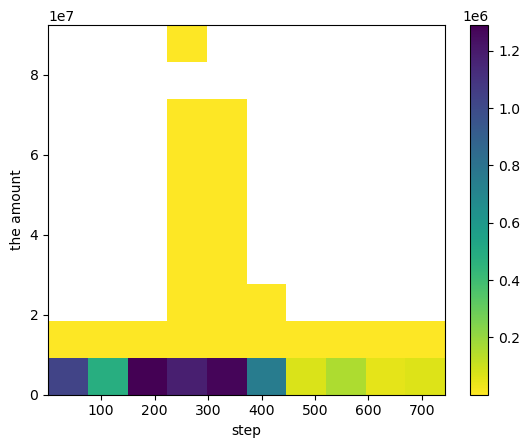

In [13]:
plt.hist2d(data= df, x = 'step', y = 'amount', cmin = 0.5,
    cmap = 'viridis_r' )
plt.colorbar()
plt.xlabel('step')
plt.ylabel('the amount')
plt.show()    

the largest amount between 200 and 300 steps i.e  during these time intervals (hours), a relatively larger number of transactions with higher monetary amounts occurred.

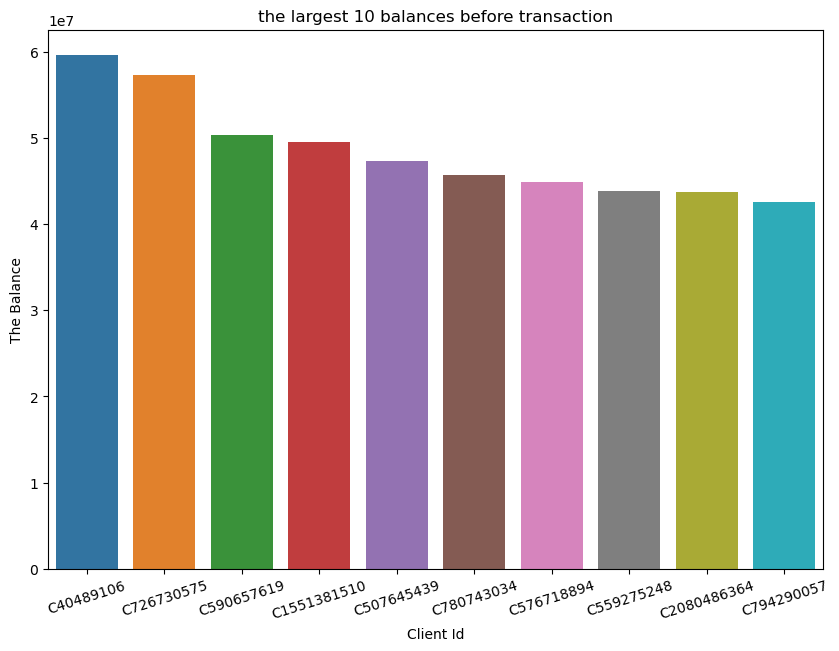

In [14]:
plt.figure(figsize = [10,7])
sns.barplot(x = df.nlargest(10, 'oldbalanceOrg').nameOrig, y = df.nlargest(10, 'oldbalanceOrg').oldbalanceOrg)
plt.xticks(rotation = 17.5)
plt.title('the largest 10 balances before transaction')
plt.xlabel('Client Id')
plt.ylabel('The Balance')
plt.show()

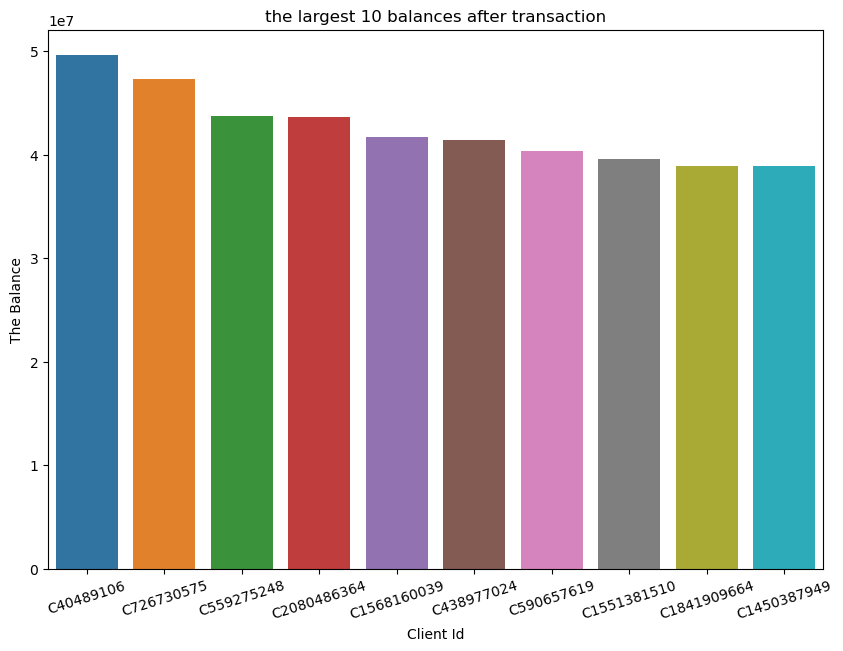

In [15]:
plt.figure(figsize = [10,7])
sns.barplot(x = df.nlargest(10, 'newbalanceOrig').nameOrig, y = df.nlargest(10, 'newbalanceOrig').newbalanceOrig)
plt.xticks(rotation = 17.5)
plt.title('the largest 10 balances after transaction')
plt.xlabel('Client Id')
plt.ylabel('The Balance')
plt.show()

for the largest 10 clients we don't see any change in the balance between the before and after transaction

In [16]:
# get top 10 most frequent client distination id
n = 10
df['nameDest'].value_counts()[:n]

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

and here we can say there's an fraud detection because some distination clients like the first one which has 113 transaction some thing may be wrong here and so on

for the distination client id C1286084959 let's see the largest amount of money transfer and is fraud or not

In [17]:
df[df.nameDest == 'C1286084959']


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
93,1,TRANSFER,583848.46,C1839168128,0.00,0.00,C1286084959,667778.00,2107778.11,0,0
367,1,TRANSFER,176334.26,C169880779,45136.00,0.00,C1286084959,1251626.46,2107778.11,0,0
388,1,CASH_OUT,373068.26,C1047934137,20034.00,0.00,C1286084959,1427960.73,2107778.11,0,0
471,1,CASH_IN,403418.39,C848097505,3834666.95,4238085.34,C1286084959,1801028.99,2107778.11,0,0
642,1,CASH_IN,222126.95,C870322840,6688712.64,6910839.59,C1286084959,1397610.60,2107778.11,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4810092,346,CASH_OUT,84205.39,C86576996,0.00,0.00,C1286084959,61680519.75,61764725.14,0,0
4832993,347,CASH_OUT,235564.75,C1068656420,0.00,0.00,C1286084959,61764725.14,62000289.89,0,0
5566959,393,CASH_IN,119568.31,C1878371174,8348248.96,8467817.28,C1286084959,62000289.89,61880721.58,0,0
5596560,394,CASH_OUT,381887.53,C1789981744,50447.00,0.00,C1286084959,61880721.58,62262609.11,0,0


In [18]:
new_data = df[df.nameDest == 'C1286084959']
new_data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,113.000000,1.130000e+02,1.130000e+02,1.130000e+02,1.130000e+02,1.130000e+02,113.0,113.0
mean,48.654867,6.852119e+05,1.528629e+06,1.578053e+06,1.302417e+07,1.429012e+07,0.0,0.0
std,100.229627,2.616135e+06,2.634386e+06,2.717605e+06,1.468275e+07,1.511047e+07,0.0,0.0
min,1.000000,2.373110e+03,0.000000e+00,0.000000e+00,6.677780e+05,1.378570e+06,0.0,0.0
25%,3.000000,1.196750e+05,0.000000e+00,0.000000e+00,2.539946e+06,2.107778e+06,0.0,0.0
50%,8.000000,2.467958e+05,2.812300e+04,0.000000e+00,1.101671e+07,1.295976e+07,0.0,0.0
75%,17.000000,4.250524e+05,2.395084e+06,2.562312e+06,1.773507e+07,1.877455e+07,0.0,0.0
max,401.000000,2.130032e+07,1.092285e+07,1.104356e+07,6.226261e+07,6.245186e+07,0.0,0.0


In [19]:
new_data[new_data.newbalanceDest == new_data.newbalanceDest.max()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5792331,401,CASH_OUT,189251.84,C1256632176,22224.0,0.0,C1286084959,62262609.11,62451860.94,0,0


 the transaction amount and the difference between "newbalanceDest" and "oldbalanceDest" are equal. However, it's important to note that before the transaction, the account balance was only 22,224.0 units, which is less than the transaction amount. Despite this, the "isFraud" value is marked as 0, indicating no fraud. While this might seem suspicious, it doesn't necessarily prove fraud. Other reasons like bank features allowing overdrafts or mistakes in transaction details could explain this. We need more analysis to be sure.

great in spite of that the client frequent about 113 times but it hasn't any fraud transaction

In [20]:
# Dropping columns that are not needed
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


### Data preprocessing


#### balancing the data 

In [21]:
## as above we have observed our data is not balanced properly 
# class count
class_count_0, class_count_1 = df['isFraud'].value_counts()

# Separate class
class_0 = df[df['isFraud'] == 0]
class_1 = df[df['isFraud'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (6354407, 8)
class 1: (8213, 8)


already data size is too big if we apply oversampling technique it will incrrease the memory usage and computation time and also increase the risk of overfitting

total class of 1 and 0: isFraud
0    8213
1    8213
Name: count, dtype: int64


<Axes: title={'center': 'count (target)'}, xlabel='isFraud'>

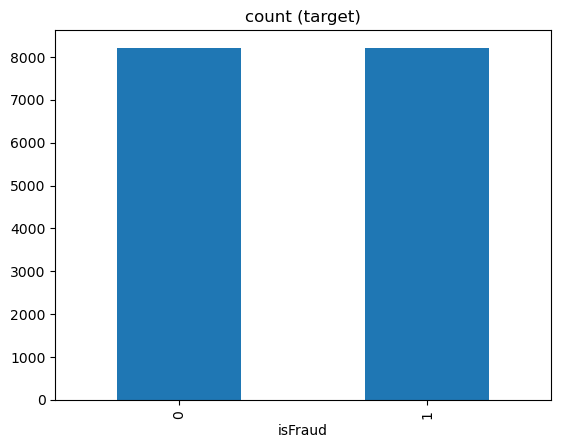

In [22]:
## undersampling technique
class_0_under = class_0.sample(class_count_1)

df = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and 0:",df['isFraud'].value_counts())# plot the count after under-sampeling
df['isFraud'].value_counts().plot(kind='bar', title='count (target)')

In [23]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,16426.000000,1.642600e+04,1.642600e+04,1.642600e+04,1.642600e+04,1.642600e+04,16426.000000
mean,306.103616,8.164742e+05,1.265404e+06,5.475663e+05,8.017494e+05,1.225072e+06,0.500000
std,194.106454,1.855679e+06,3.349171e+06,2.636653e+06,3.149966e+06,3.540005e+06,0.500015
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,161.000000,3.555326e+04,1.008350e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,284.000000,1.675998e+05,1.168437e+05,0.000000e+00,0.000000e+00,1.132976e+05,0.500000
75%,410.000000,5.344172e+05,7.810592e+05,0.000000e+00,5.000468e+05,1.066572e+06,1.000000
max,743.000000,2.425424e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,1.000000


In [24]:
df['isFraud'].value_counts()

isFraud
0    8213
1    8213
Name: count, dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16426 entries, 4438435 to 6362619
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            16426 non-null  int64  
 1   type            16426 non-null  object 
 2   amount          16426 non-null  float64
 3   oldbalanceOrg   16426 non-null  float64
 4   newbalanceOrig  16426 non-null  float64
 5   oldbalanceDest  16426 non-null  float64
 6   newbalanceDest  16426 non-null  float64
 7   isFraud         16426 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 1.1+ MB


#### Applying one-hot-encoding on type column

In [26]:

df = pd.get_dummies(df, columns=['type'])
# Convert boolean columns to integer (0 and 1)
boolean_columns = df.select_dtypes(include=[bool]).columns
df[boolean_columns] = df[boolean_columns].astype(int)

df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
4438435,323,8856.32,0.00,0.00,0.00,0.00,0,0,0,0,1,0
5729475,399,393267.27,12572945.11,12966212.38,1481968.65,1088701.38,0,1,0,0,0,0
5623876,395,201072.68,0.00,0.00,7129453.48,7330526.16,0,0,1,0,0,0
4238379,306,162626.84,38393.00,0.00,9906.38,172533.23,0,0,1,0,0,0
4385297,312,498017.15,1162593.45,1660610.60,901945.38,403928.23,0,1,0,0,0,0


In [27]:
df['type_CASH_IN'].value_counts()

type_CASH_IN
0    14680
1     1746
Name: count, dtype: int64

In [28]:
df['type_CASH_OUT'].value_counts()


type_CASH_OUT
0    9407
1    7019
Name: count, dtype: int64

In [29]:
df['type_DEBIT'].value_counts()

type_DEBIT
0    16374
1       52
Name: count, dtype: int64

In [30]:
df['type_PAYMENT'].value_counts()

type_PAYMENT
0    13565
1     2861
Name: count, dtype: int64

In [31]:
df['type_TRANSFER'].value_counts()

type_TRANSFER
0    11678
1     4748
Name: count, dtype: int64

type_DEBIT: 62 < type_CASH_IN: 1819 ,< type_Payment: 2834 < type_TRANSFER: 4774,   < type_CASH_OUT: 6967

now after balancing the data statistics are changed but still  The high count of cash-out transactions raise concerns about fraudulent or suspicious activities, as these transactions involve withdrawing cash from accounts.




#### checking the outliers and distribution of data

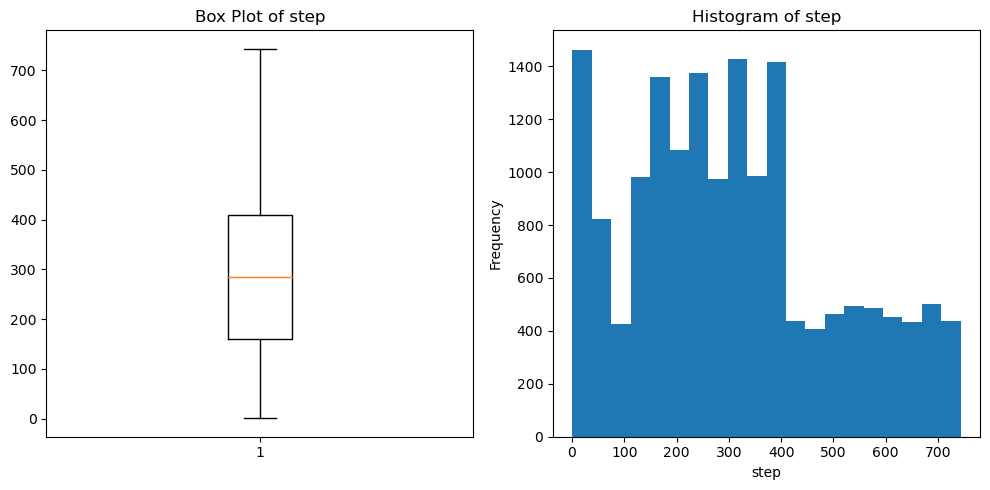

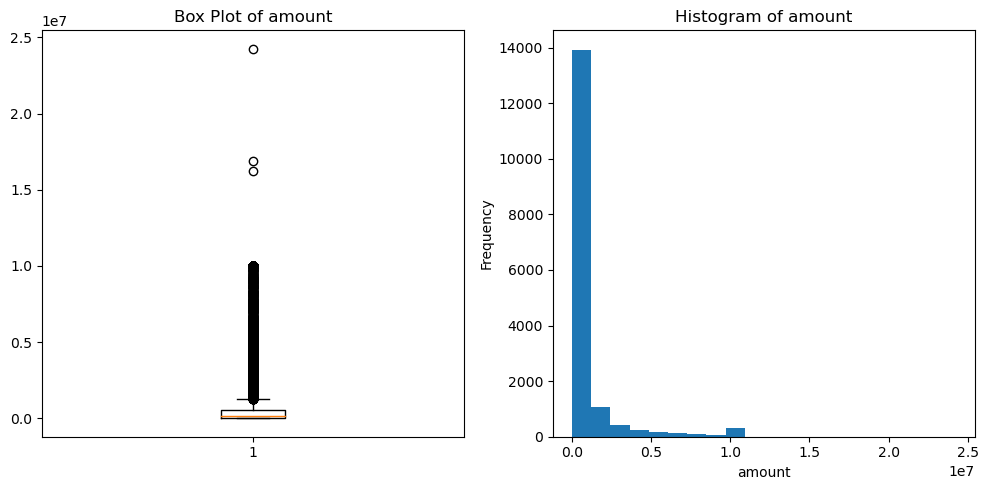

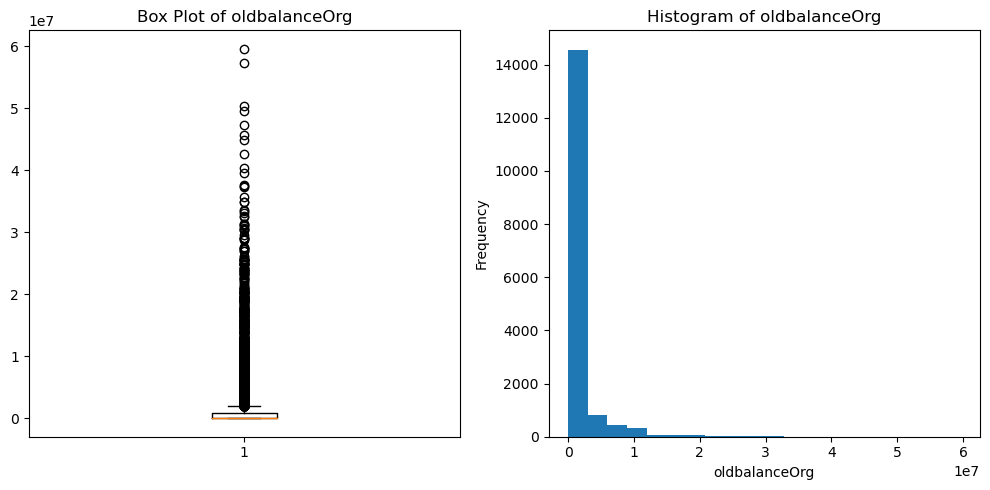

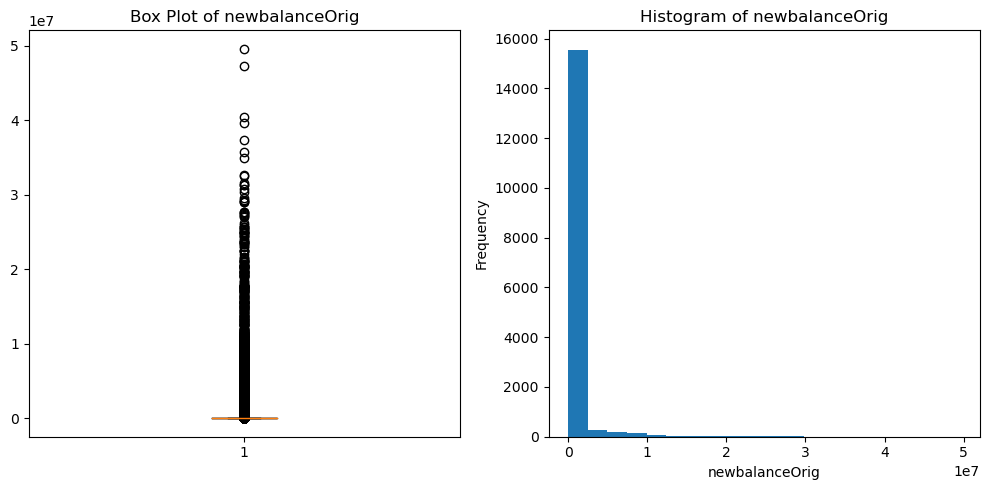

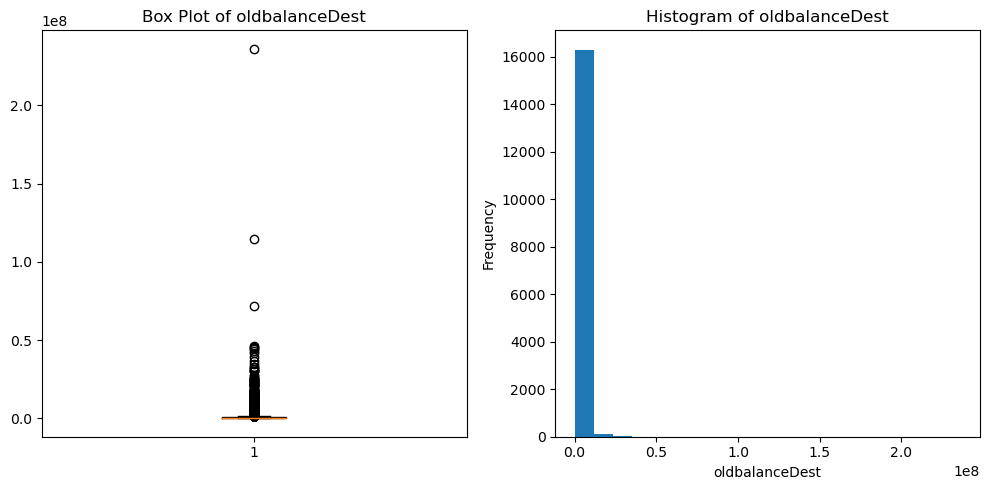

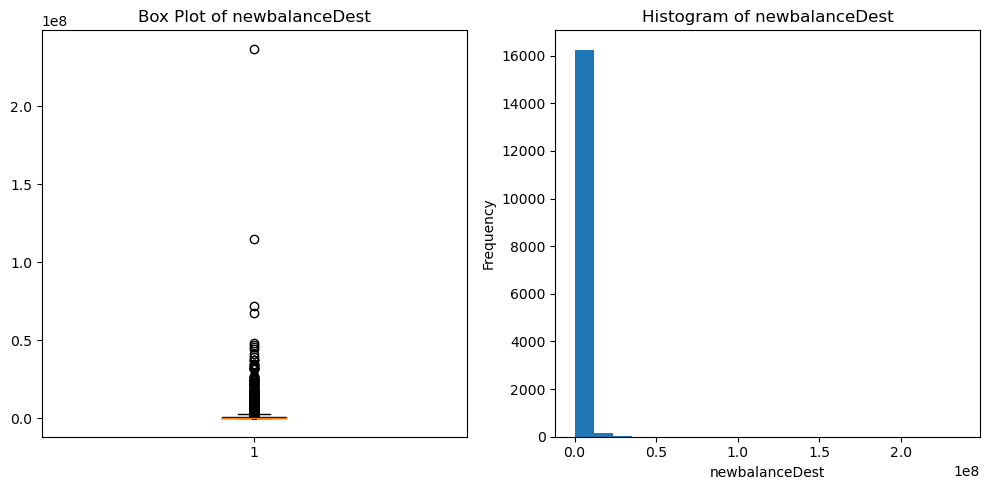

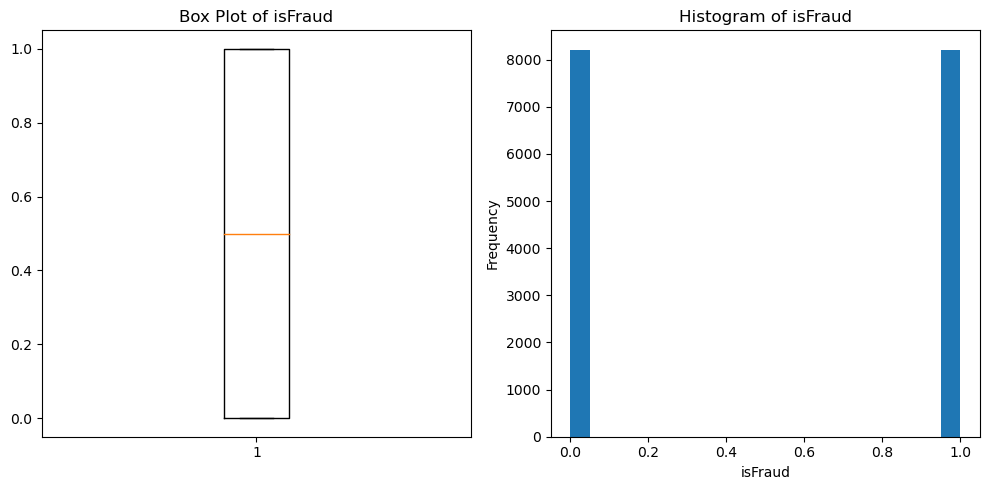

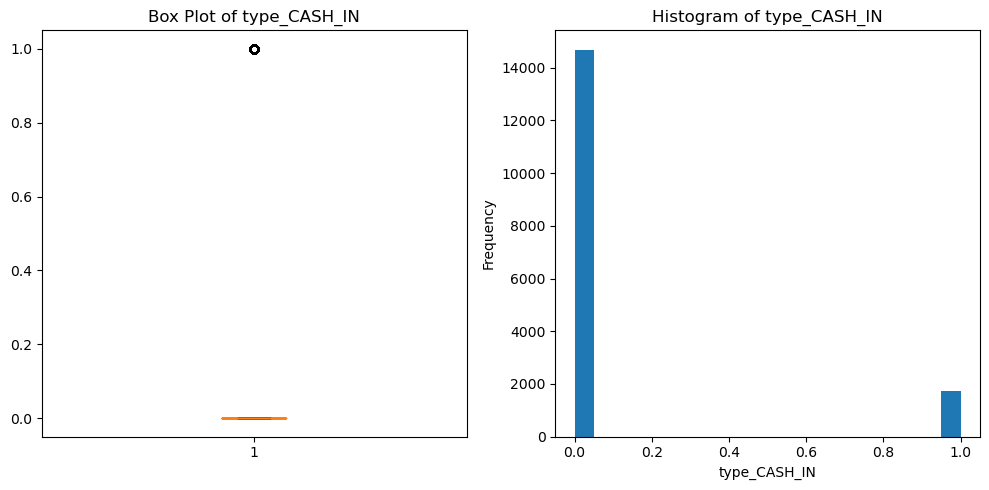

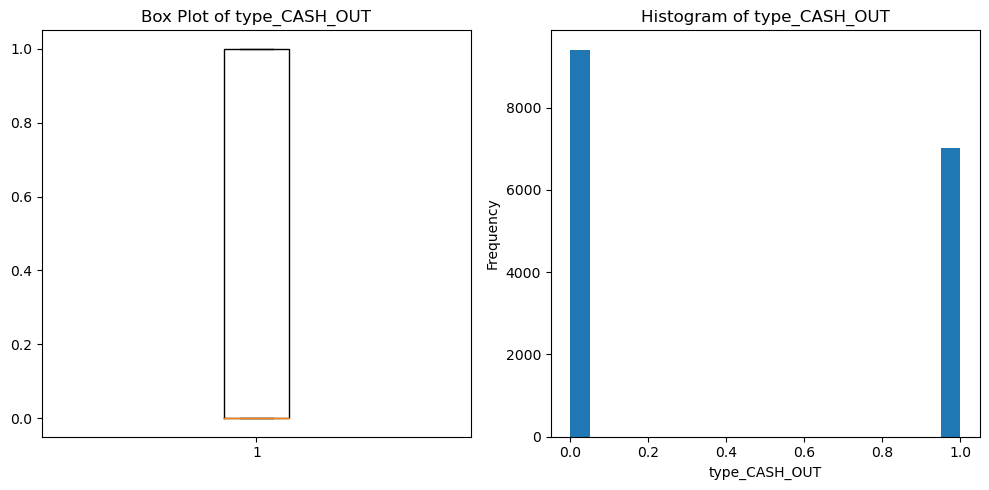

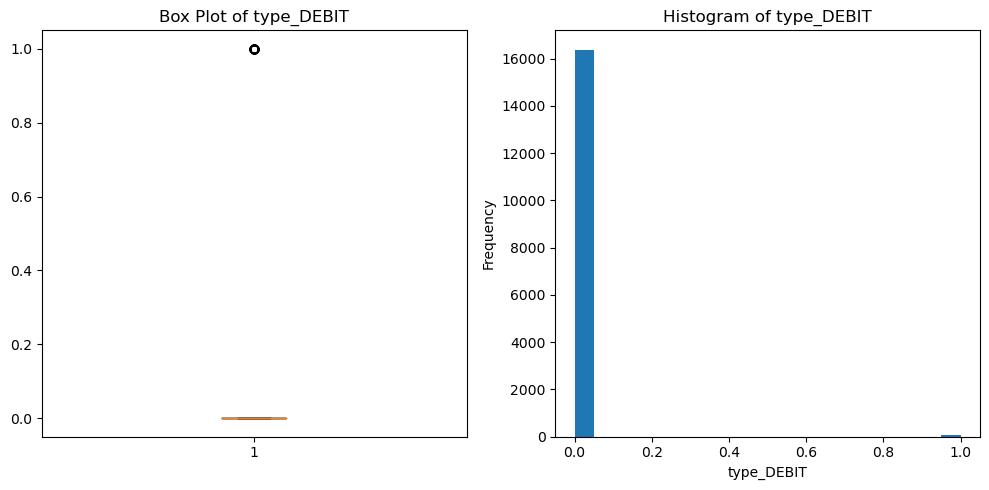

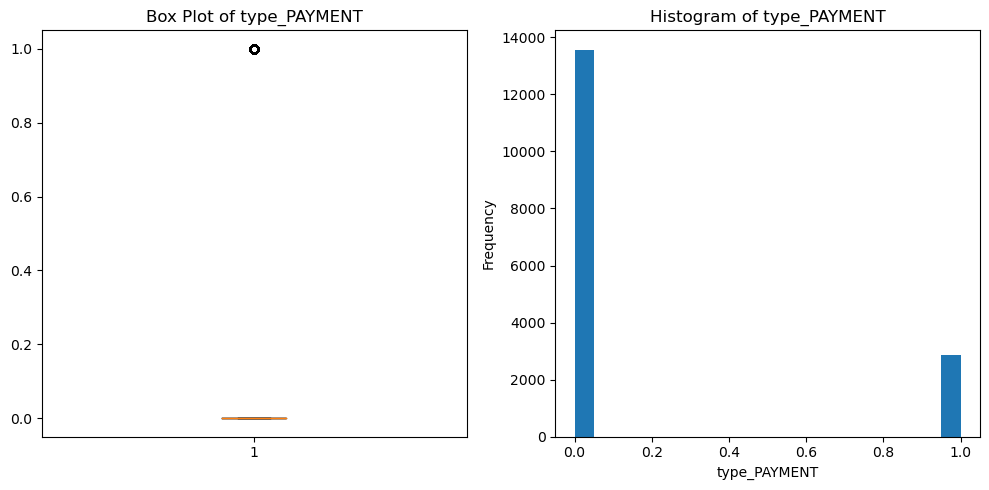

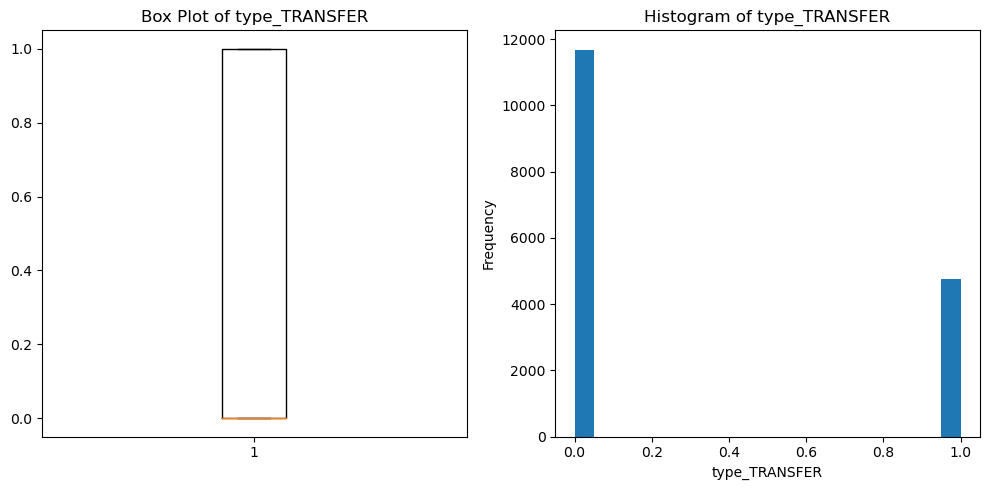

In [32]:
for column in df.columns:
    if df[column].dtype != 'object':  # Only consider numeric columns
        plt.figure(figsize=(10, 5))
        
        # Box Ploxt
        plt.subplot(1, 2, 1)
        plt.boxplot(df[column])
        plt.title(f'Box Plot of {column}')
        
        # Histogram
        plt.subplot(1, 2, 2)
        plt.hist(df[column], bins=20)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

In [34]:
mean_values = df.mean()

# Calculate the median for each column
median_values = df.median()

pd.set_option('display.float_format', '{:.2f}'.format)

# Print mean and median values
print("Mean values of columns:")
print(mean_values)
print("\nMedian values of columns:")
print(median_values)

Mean values of columns:
step                 306.10
amount            816474.23
oldbalanceOrg    1265403.73
newbalanceOrig    547566.31
oldbalanceDest    801749.39
newbalanceDest   1225071.81
isFraud                0.50
type_CASH_IN           0.11
type_CASH_OUT          0.43
type_DEBIT             0.00
type_PAYMENT           0.17
type_TRANSFER          0.29
dtype: float64

Median values of columns:
step                284.00
amount           167599.81
oldbalanceOrg    116843.69
newbalanceOrig        0.00
oldbalanceDest        0.00
newbalanceDest   113297.62
isFraud               0.50
type_CASH_IN          0.00
type_CASH_OUT         0.00
type_DEBIT            0.00
type_PAYMENT          0.00
type_TRANSFER         0.00
dtype: float64


rule says if mean > median then it is right skewed or vice a versa 


Columns with right skewness:

amount

oldbalanceOrg

newbalanceOrig

oldbalanceDest

newbalanceDest

type_CASH_IN

type_CASH_OUT

type_PAYMENT

type_TRANSFER

Symmetric (No Skewness): When the mean is approximately equal to the median, the distribution is symmetric and has no skewness.

Columns with no skewness:

isFraud

type_DEBIT

When most of the dependent variables in dataset are right-skewed, 
Right-skewed distributions often have outliers or extreme values on the right side of the distribution. 

In [36]:
#using iqr method to handle outliers as data is skewed 

outliers = {}

for col in df:
    column_values = df[col]
    Q1 = column_values.quantile(0.25)
    Q3 = column_values.quantile(0.75)
    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    
    print(f"Column: '{col}'")
    print(f"low_limit is {low_lim}")
    print(f"up_limit is {up_lim}")
    
    column_outliers = column_values[(column_values < low_lim) | (column_values > up_lim)]
    outliers[col] = column_outliers

    print(f"Count of outliers in column '{col}': {len(column_outliers)}")
    print("\n")


Column: 'step'
low_limit is -212.5
up_limit is 783.5
Count of outliers in column 'step': 0


Column: 'amount'
low_limit is -712742.6674999999
up_limit is 1282713.1524999999
Count of outliers in column 'amount': 2406


Column: 'oldbalanceOrg'
low_limit is -1146379.9974999998
up_limit is 1937522.6624999996
Count of outliers in column 'oldbalanceOrg': 2523


Column: 'newbalanceOrig'
low_limit is 0.0
up_limit is 0.0
Count of outliers in column 'newbalanceOrig': 3641


Column: 'oldbalanceDest'
low_limit is -750070.155
up_limit is 1250116.925
Count of outliers in column 'oldbalanceDest': 2427


Column: 'newbalanceDest'
low_limit is -1599858.6712500001
up_limit is 2666431.1187500004
Count of outliers in column 'newbalanceDest': 2089


Column: 'isFraud'
low_limit is -1.5
up_limit is 2.5
Count of outliers in column 'isFraud': 0


Column: 'type_CASH_IN'
low_limit is 0.0
up_limit is 0.0
Count of outliers in column 'type_CASH_IN': 1746


Column: 'type_CASH_OUT'
low_limit is -1.5
up_limit is 2.5
Co

#### after checking the outliers it is important to know reason behind there presence 

1. step:

No outliers are present in this column.It seems that the "step" values are within the expected range, which is a positive sign.

2. amount:
Large transaction amounts indicative of unusual activities. might need to investigate whether these outliers are due to legitimate high-value transactions or if they indicate potential fraud.

3. oldbalanceOrg and oldbalanceDest:

Outliers here might suggest that certain originating accounts had unusually high or low balances before transactions. Investigate whether these outliers are due to specific patterns or anomalies.

4. newbalanceOrig:

All values in the "newbalanceOrig" column are 0, which might indicate an issue need to verify that if this column is correctly capturing the new balances after transactions.

note : Always ensure that any preprocessing steps, including scaling, imputation, and outlier handling, are applied only to the feature columns and not to the target variable. This helps maintain the integrity of your data and ensures that your model is trained and evaluated correctly.

#### train and test split 

In [37]:
x = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    random_state=0,
                                                    stratify=y,
                                                    test_size=0.2)

print(f'shape X_train: {X_train.shape}')
print(f'shape X_test: {X_test.shape}')
print(f'shape y_train: {y_train.shape}')
print(f'shape y_test: {y_test.shape}')

shape X_train: (13140, 11)
shape X_test: (3286, 11)
shape y_train: (13140,)
shape y_test: (3286,)


In [38]:
X_train.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

after seeing the above statistics it is clear that data is right skewed and contain outliers in heavy amount so we cannot apply iqr trimming method to handle them as it can lead to loss of important information lets try with capping method 

In [39]:
outliers = {}
X_train_capped = X_train.copy()

for col in X_train.columns:
    column_values = X_train[col]
    Q1 = column_values.quantile(0.25)
    Q3 = column_values.quantile(0.75)
    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    print(f'Shape of {col} before capping: {X_train[col].shape}')
    # Apply capping to the current column
    X_train_capped[col] = column_values.clip(lower=low_lim, upper=up_lim)

    # Print the shape of the current column after capping
    print(f'Shape of {col} after capping: {X_train_capped[col].shape}')

# Print the shape of X_train after capping
print(f'Shape of X_train after capping: {X_train_capped.shape}')


Shape of step before capping: (13140,)
Shape of step after capping: (13140,)
Shape of amount before capping: (13140,)
Shape of amount after capping: (13140,)
Shape of oldbalanceOrg before capping: (13140,)
Shape of oldbalanceOrg after capping: (13140,)
Shape of newbalanceOrig before capping: (13140,)
Shape of newbalanceOrig after capping: (13140,)
Shape of oldbalanceDest before capping: (13140,)
Shape of oldbalanceDest after capping: (13140,)
Shape of newbalanceDest before capping: (13140,)
Shape of newbalanceDest after capping: (13140,)
Shape of type_CASH_IN before capping: (13140,)
Shape of type_CASH_IN after capping: (13140,)
Shape of type_CASH_OUT before capping: (13140,)
Shape of type_CASH_OUT after capping: (13140,)
Shape of type_DEBIT before capping: (13140,)
Shape of type_DEBIT after capping: (13140,)
Shape of type_PAYMENT before capping: (13140,)
Shape of type_PAYMENT after capping: (13140,)
Shape of type_TRANSFER before capping: (13140,)
Shape of type_TRANSFER after capping: 

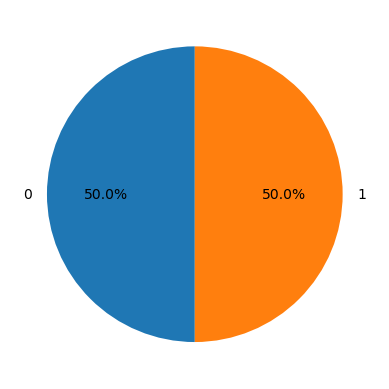

In [ ]:
fraud = df['isFraud'].value_counts()
fraud_idx = fraud.index
fraud_val = fraud.values

plt.pie(fraud_val,
        labels=fraud_idx,
        autopct='%1.1f%%',
        startangle=90)
plt.show()

##### calculating the mutual information for feature importance 

In [ ]:
mi_scores = mutual_info_classif(X_train_capped, y_train, random_state=42)

mi_df = pd.DataFrame({'Feature': X_train_capped.columns, 'Mutual_Information': mi_scores})

mi_df_sorted = mi_df.sort_values(by='Mutual_Information', ascending=False)
mi_df_sorted


,Feature,Mutual_Information
0,step,0.29
2,oldbalanceOrg,0.26
1,amount,0.24
10,type_TRANSFER,0.11
4,oldbalanceDest,0.03
7,type_CASH_OUT,0.01
5,newbalanceDest,0.01
6,type_CASH_IN,0.00
3,newbalanceOrig,0.00
8,type_DEBIT,0.00


In [ ]:
mi = mi_df_sorted[mi_df_sorted['Mutual_Information'] > 0]['Feature']
mi


0               step
2      oldbalanceOrg
1             amount
10     type_TRANSFER
4     oldbalanceDest
7      type_CASH_OUT
5     newbalanceDest
6       type_CASH_IN
3     newbalanceOrig
Name: Feature, dtype: object

In [ ]:
X_train = X_train[mi]
X_train.head()



,step,oldbalanceOrg,amount,type_TRANSFER,oldbalanceDest,type_CASH_OUT,newbalanceDest,type_CASH_IN,newbalanceOrig
2380616,193,113273.10,113273.10,1,0.00,0,0.00,0,0.00
3196165,249,271229.80,271229.80,1,0.00,0,0.00,0,0.00
6308246,685,10000000.00,10000000.00,0,56142.18,1,10056142.18,0,0.00
6080971,520,5469910.99,5469910.99,1,0.00,0,0.00,0,0.00
3923678,285,104855.00,5498.40,0,0.00,0,0.00,0,99356.60


In [41]:
X_test = X_test[X_train.columns]
X_test.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
3190161,240,1438.16,537.00,0.00,0.00,0.00,0,0,0,1,0
532615,20,231137.31,0.00,0.00,690622.65,921759.96,0,1,0,0,0
4172602,304,12990.40,0.00,0.00,0.00,0.00,0,0,0,1,0
6246560,596,417236.81,9314111.39,9731348.20,471695.49,54458.68,1,0,0,0,0
5372230,376,175284.28,20878.00,196162.28,1575373.18,1400088.90,1,0,0,0,0


In [42]:
X_test.shape

(3286, 11)

In [43]:
## below listed models are commonly used for classification 
models = {
    "LR": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVC": SVC()

}

In [44]:
for name, model in models.items():
    print(f'Training Model {name} \n--------------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Training Accuracy: {accuracy_score(y_train, model.predict(X_train))}')
    print(f'Testing Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Testing Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
    print("Recall Score : ", recall_score(y_test, y_pred, pos_label=1, average='binary'))
    print("Precision Score : ", precision_score(y_test, y_pred, pos_label=1, average='binary'))


Training Model LR 
--------------
Training Accuracy: 0.9074581430745814
Testing Accuracy: 0.9001825928180158
Testing Confusion Matrix: 
[[1501  142]
 [ 186 1457]]
Recall Score :  0.8867924528301887
Precision Score :  0.9111944965603502
Training Model KNN 
--------------
Training Accuracy: 0.9700152207001522
Testing Accuracy: 0.9519172245891662
Testing Confusion Matrix: 
[[1563   80]
 [  78 1565]]
Recall Score :  0.9525258673158856
Precision Score :  0.9513677811550152
Training Model DT 
--------------
Training Accuracy: 1.0
Testing Accuracy: 0.9905660377358491
Testing Confusion Matrix: 
[[1622   21]
 [  10 1633]]
Recall Score :  0.9939135727328059
Precision Score :  0.9873035066505441
Training Model RF 
--------------
Training Accuracy: 1.0
Testing Accuracy: 0.9905660377358491
Testing Confusion Matrix: 
[[1616   27]
 [   4 1639]]
Recall Score :  0.9975654290931223
Precision Score :  0.9837935174069627
Training Model XGB 
--------------
Training Accuracy: 0.999923896499239
Testing Accur

#### conclusion


it's generally preferable to have a higher number of false positives (FP > FN). because it prioritizes minimizing the risk of missing actual fraudulent transactions (false negatives) and  In cases where false positives are minimized at the cost of higher false negatives,that means actual fraudulent transactions might go unnoticed, leading to financial losses and security breaches.

1. Decision Tree (DT):


2. Random Forest (RF):


3. XGBoost (XGB):

These models performs good from others in terms of both accuracy and the ability to identify positive cases (high recall), which is often crucial in many real-world applications. Their precision scores are also quite high, indicating accurate positive predictions.
